In [ ]:
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.3 MB/s eta 0:00:44tcmalloc: large alloc 1147494400 bytes == 0x6630c000 @  0x7efff08a7615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 890.2 MB 5.5 kB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
     |████████████████████████████████| 849 kB 57.7 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 317.1 MB 31 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolve

{'status': 'ok', 'restart': True}

In [ ]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
%matplotlib inline

In [231]:
from functorch import vmap, vjp
from functorch import jacrev, jacfwd

class NNApproximator(nn.Module):
  def __init__(self, dim_input = 1, dim_output = 2, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
    super().__init__()

    self.layer_in = nn.Linear(dim_input, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, dim_output)
    # self.A = nn.Parameter(torch.randn(2,2))
    self.k = nn.Parameter(torch.rand(1, requires_grad=True))
    # self.A = self.k * torch.from_numpy(np.array([[-1,1],[1,-1]]))

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.activation = activation

  def forward(self, t):
    out = self.activation(self.layer_in(t))
    for layer in self.middle_layers:
      out = self.activation(layer(out))
    return self.layer_out(out)

  # reference for implementing derivatives for batched inputs
  # https://pytorch.org/functorch/stable/notebooks/jacobians_hessians.html
  def jacobian(self, t):
    jac = vmap(jacfwd(self.forward))
    return jac(t).squeeze()

  def hessian(self, t):
    hess = vmap(jacfwd(jacfwd(self.forward)))
    return hess(t).squeeze()


Text(0.5, 0, '$\\epsilon$')

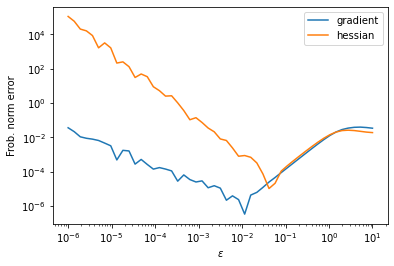

In [ ]:
# model = NNApproximator(num_hidden=5, dim_hidden=32)

# t = torch.linspace(1,1,6).reshape(-1,1)
# t.requires_grad = True

# vec = torch.ones(t.shape)

# err_grads = []
# err_hess = []
# eps_vals = np.logspace(1,-6,51)

# def grad_fd_fn(f, t, eps):
#   return 1/(2*eps) * (f(t + torch.ones(t.shape) * eps) - f(t - torch.ones(t.shape) * eps))

# def hess_fd_fn(f, t, eps):
#   return 1/(eps**2) * (f(t + torch.ones(t.shape) * eps) - 2*f(t) + f(t - torch.ones(t.shape) * eps))

# for myeps in eps_vals:
#   # mygrad = torch.autograd.grad(mydf[:,0], t, vec.ravel(), retain_graph=True)[0]
#   # mygrad2 = torch.autograd.grad(mydf[:,1], t, vec.ravel(), retain_graph=True)[0]
#   # mygrad = torch.hstack((mygrad, mygrad2))

#   mygrad = model.jacobian(t)

#   # grad_fd = ((f(model, t+vec*myeps) - f(model, t-vec*myeps)) / (2*myeps))
#   grad_fd = grad_fd_fn(model.forward, t, myeps)
#   err_grads.append(torch.linalg.matrix_norm(grad_fd - mygrad).detach().numpy())

#   myhess = model.hessian(t)
#   # hess_fd = ((f(model, t+vec*myeps) - 2*f(model, t) + f(model, t-vec*myeps)) / (myeps**2))
#   hess_fd = hess_fd_fn(model.forward, t, myeps)
#   err_hess.append(torch.linalg.matrix_norm(hess_fd - myhess).detach().numpy())


# plt.loglog(eps_vals, err_grads, label='gradient')
# plt.loglog(eps_vals, err_hess, label='hessian')
# plt.legend()
# plt.ylabel("Frob. norm error")
# plt.xlabel("$\epsilon$")

In [255]:
def compute_PINN_loss(model, t):
  # omega = 1.8
  # A = model.A
  A = model.k * torch.from_numpy(np.array([[-1, 1],[1, -1]]))
  t_bc = 0.0      # input value where boundary condition is specified
  x_bc = torch.from_numpy(
      np.array([-1.0,1.0]))      # value of x = A*sin(wt) + B*cos(wt) at the boundary
  xdot_bc = torch.from_numpy(
      np.array([0.0,0.0]))   # value of xdot at the boundary

  # calculate ODE residual at collocation points

  # using training data... the canonical method is NOT to do this, but use the NN's variables wherever possible.
  # Since the NN predicts x(t), we should use model.forward(t) instead of the training data x_tr.
  x_nn     = model.forward(t)
  xddot_nn  = model.hessian(t)
  xdot_nn  = model.jacobian(t)
  ode_residual = xddot_nn - (x_nn @ A.T)
  # ode_residual = xdot_nn - x_nn @ A.T
  ode_loss = 0.5 * torch.mean(ode_residual ** 2)
  # ode_loss += torch.mean((model.A - model.A.T) ** 2)

  # print("X: ", x_nn.shape)
  # print("Xdot: ", xdot_nn.shape)

  # apply energy conservation loss
  # eigval = model.k * 2
  E0 = model.k * (x_bc[0] - x_bc[1])**2 + xdot_bc[0]**2 + xdot_bc[1]**2
  E = model.k * (x_nn[:,0] - x_nn[:,1])**2 + xdot_nn[:,0]**2 + xdot_nn[:,1]**2

  # E  = (eigval) * x_nn**2 + xdot_nn**2
  # E0 = (omega**2) * x_bc**2 + xdot_bc**2
  # E  = (omega**2) * x_nn**2 + xdot_nn**2
  energy_loss = 0.5 * torch.mean((E0 - E) ** 2)
  # print(energy_loss)

  # eigval = torch.linalg.eigvals(model.A)
  # # nullspace/rigid motion eigenmode
  # eig_loss = eigval[0].abs()**2
  # # # if len(eigval) > 1:
  # # #   # remaining eigenmodes should preserve energy?
  # # #   eig_loss += torch.mean((eigval[1:].abs() - 1)**2)
  # ode_loss += eig_loss

  # calculate loss to match boundary condition
  t_bc = torch.tensor([t_bc], requires_grad=True).reshape(-1,1)
  # x_bc = torch.tensor([x_bc], requires_grad=False)
  x_bc_nn = model.forward(t_bc)
  xdot_bc_nn = model.jacobian(t_bc)
  bc_loss = 0.5 * torch.mean((x_bc_nn - x_bc) ** 2) + \
            0.5 * torch.mean((xdot_bc_nn - xdot_bc) ** 2)

  # print("Xbc: ", x_bc.shape)
  # print("Xbc_nn: ", x_bc_nn.shape)
  # print("Xdbc: ", xdot_bc.shape)
  # print("Xdbc_nn: ", xdot_bc_nn.shape)


  return ode_loss + bc_loss + 1e-2 * energy_loss

In [233]:
def compute_data_loss(model, t_tr, x_tr):
  return 0.5 * torch.mean((model.forward(t_tr) - x_tr) ** 2)

In [234]:
def train_model(model, data_loss_fn, PINN_loss_fn, learning_rate=0.0001, max_epochs=1000):
  tr_losses = []

  # reference on torch.LBFGS usage
  # https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20
  USE_BFGS = False

  if USE_BFGS:
    optimizer = torch.optim.LBFGS(model.parameters())
    print("Using BFGS optimizer ... ")
    log_iter = 10
    def closure():
        optimizer.zero_grad()
        objective = data_loss_fn(model) + PINN_loss_fn(model)
        objective.backward()
        return objective
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    print("Using Adam optimizer ... ")
    log_iter = 1000

  for epoch in range(max_epochs):
    loss = data_loss_fn(model) + PINN_loss_fn(model)
    if USE_BFGS:
      optimizer.step(closure)
    else:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch % log_iter == 0:
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")
    tr_losses.append(loss.detach().numpy())

  return model, np.array(tr_losses)

In [256]:
# analytical solution
k_truth = 1.7
x = lambda t: torch.from_numpy(
    np.concatenate(
        (-np.cos(np.sqrt(2*k_truth)*t), np.cos(np.sqrt(2*k_truth)*t)),
        axis=1))

domain = [0.0, 7.0]

# data for NN solution to match
t_tr = torch.linspace(domain[0], domain[1], steps=51)
t_tr = t_tr.reshape(-1, 1)
x_tr = x(t_tr.detach())
# x_tr.reshape(t_tr.shape)

# collocation points for ODE loss
# t_PINN requires grad because this is the NN's input vector for evaluating the ODE loss
t_tr_PINN = torch.linspace(domain[0], 2*domain[1], steps=201, requires_grad=True)
t_tr_PINN = t_tr_PINN.reshape(-1, 1)

nn_approximator = NNApproximator(1, 2, num_hidden=6, dim_hidden=30)
# assert check_gradient(nn_approximator, x)

nn_tr, tr_losses = train_model(
    nn_tr,
    data_loss_fn=lambda model: compute_data_loss(model, t_tr, x_tr),
    PINN_loss_fn=lambda model: 1e0*compute_PINN_loss(model, t_tr_PINN),
    learning_rate=0.001,
    max_epochs=20000,
)

# domain_te = [0.0, 20.0]
# t_te = torch.linspace(domain_te[0],domain_te[1],steps=200).reshape(-1,1)
# x_te = x(t_te.detach())

# fig, ax = plt.subplots(2,1, figsize=(8,12))
# f_te = f(nn_tr, t_te)
# ax[0].scatter(t_tr.detach().numpy(), x_tr.detach().numpy(), label='Sample points')
# ax[0].scatter(t_tr_PINN.detach().numpy(), x(t_tr_PINN.detach()).detach().numpy(), label='PINN colloc. points')
# ax[0].plot(t_te.detach().numpy(), x_te.detach().numpy(),label='Truth')
# ax[0].plot(t_te.detach().numpy(), f_te.detach().numpy(), label='NN solution')
# ax[0].legend()

# ax[1].semilogy(t_te.detach().numpy(), np.abs(f_te.detach().numpy() - x_te.detach().numpy()))
# ax[1].set_xlim(domain)
# ax[1].set_title("Approximation error inside training domain")

Using Adam optimizer ... 
Epoch: 0 - Loss: 0.001182
Epoch: 1000 - Loss: 0.013949
Epoch: 2000 - Loss: 0.004783
Epoch: 3000 - Loss: 0.000115
Epoch: 4000 - Loss: 0.000098
Epoch: 5000 - Loss: 0.000110
Epoch: 6000 - Loss: 0.006390
Epoch: 7000 - Loss: 0.003200
Epoch: 8000 - Loss: 0.000439
Epoch: 9000 - Loss: 0.000081
Epoch: 10000 - Loss: 0.000496
Epoch: 11000 - Loss: 0.000102
Epoch: 12000 - Loss: 0.000421
Epoch: 13000 - Loss: 0.000074
Epoch: 14000 - Loss: 0.010913
Epoch: 15000 - Loss: 0.000045
Epoch: 16000 - Loss: 0.000046
Epoch: 17000 - Loss: 0.000049
Epoch: 18000 - Loss: 0.000049
Epoch: 19000 - Loss: 0.000240


In [257]:
# nn_tr.A
nn_tr.k
# should approximately equal A = [[-k, k], [k, -k]] where k=k_truth

Parameter containing:
tensor([1.6953], requires_grad=True)

In [258]:
# np.linalg.eig(nn_tr.A.detach().numpy())
# torch.linalg.eigvals(nn_tr.A)
# torch.linalg.eigvals(torch.from_numpy(np.array([[1.,-1.],[-1.,1.]])))

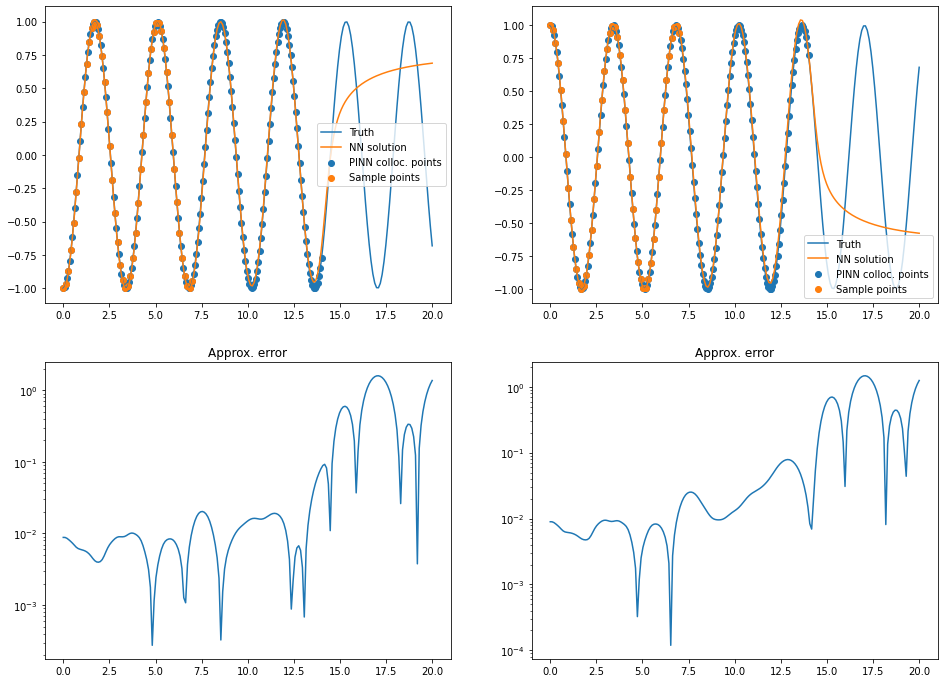

In [260]:
domain_te = [0.0, 20.0]
t_te = torch.linspace(domain_te[0],domain_te[1],steps=200, requires_grad=True).reshape(-1,1)
x_te = x(t_te.detach())

dim_x = x_te.shape[1]

fig, ax = plt.subplots(2,dim_x, figsize=(16,12))
f_te = nn_tr.forward(t_te)
for var_id in range(dim_x):
  ax[0, var_id].scatter(t_tr_PINN.detach().numpy(), x(t_tr_PINN.detach()).detach().numpy()[:,var_id], label='PINN colloc. points')
  ax[0, var_id].scatter(t_tr.detach().numpy(), x_tr.detach().numpy()[:,var_id], label='Sample points')
  ax[0, var_id].plot(t_te.detach().numpy(), x_te.detach().numpy()[:,var_id],label='Truth')
  ax[0, var_id].plot(t_te.detach().numpy(), f_te.detach().numpy()[:,var_id], label='NN solution')
  ax[0, var_id].legend()

  ax[1, var_id].semilogy(t_te.detach().numpy(), np.abs(f_te.detach().numpy()[:,var_id] - x_te.detach().numpy()[:,var_id]))
  # ax[1, var_id].set_xlim(domain)
  ax[1, var_id].set_title("Approx. error")

Text(0.5, 1.0, 'Total energy')

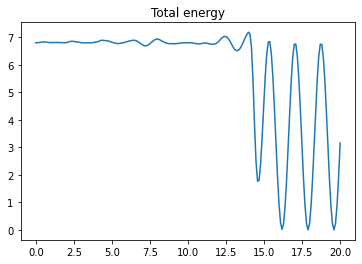

In [265]:
xdot_te = nn_tr.jacobian(t_te)

E = k_truth * (x_te[:,0] - x_te[:,1])**2 + xdot_te[:,0]**2 + xdot_te[:,1]**2

plt.plot(t_te.detach().numpy(), E.detach().numpy())
plt.title("Total energy")
# x_te.shape

In [253]:
dyn = lambda t: np.concatenate(
        (-np.cos(np.sqrt(2*k_truth)*t)[:,np.newaxis], np.cos(np.sqrt(2*k_truth)*t)[:,np.newaxis]),
        axis=1)

dyn_dot = lambda t: np.concatenate(
        (np.sqrt(2*k_truth)*np.sin(np.sqrt(2*k_truth)*t)[:,np.newaxis], -np.sqrt(2*k_truth)*np.sin(np.sqrt(2*k_truth)*t)[:,np.newaxis]),
        axis=1)

dyn_ddot = lambda t: np.concatenate(
        ((2*k_truth)*np.cos(np.sqrt(2*k_truth)*t)[:,np.newaxis], -2*(k_truth)*np.cos(np.sqrt(2*k_truth)*t)[:,np.newaxis]),
        axis=1)

t = np.linspace(0,20,61)
xs = dyn(t).T
x_dots = dyn_dot(t).T
x_ddots = dyn_ddot(t).T

At, _, _, _ = np.linalg.lstsq(xs.T, x_ddots.T, rcond=None)

np.allclose(At, k_truth*np.array([[-1,1],[1,-1]]))

True

array([6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8,
       6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8,
       6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8,
       6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8,
       6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8, 6.8])

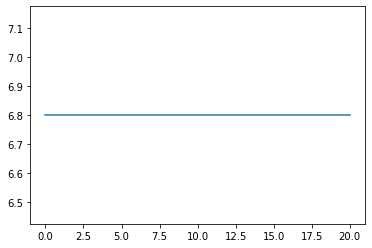

In [254]:
E = k_truth * (xs.T[:,0] - xs.T[:,1])**2 + x_dots.T[:,0]**2 + x_dots.T[:,1]**2

plt.plot(t,E)
E
# E.shape

In [ ]:
np.allclose(x_ddots, At@xs)

True

In [ ]:
t_torch = torch.linspace(domain[0], domain[1], 10, requires_grad=True).reshape(-1,1)
# print(f(nn_tr, t_torch) @ (nn_tr.k * torch.from_numpy(np.array([[-1, 1],[1, -1]]))))
# print(df(nn_tr, t_torch, order=2))
# print(df(nn_tr, t_torch,order=2))

def midpt_rule(f, t, eps):
  return 1/eps**2 * (f(t + np.ones_like(t) * eps) - 2 * f(t) + f(t - np.ones_like(t) * eps))

print(dyn_ddot(t_torch.detach().numpy()).ravel())
print(midpt_rule(dyn, t_torch.detach().numpy(), 1e-3).ravel())
print(midpt_rule(lambda t: f(nn_tr, t), t_torch.detach(), 1e-2))
print(midpt_rule(lambda t: f(nn_tr, t), t_torch.detach(), 1e-3))
print(midpt_rule(lambda t: f(nn_tr, t), t_torch.detach(), 1e-4))

[ 2.0000000e+00 -2.0000000e+00 -1.1042039e-03  1.1042039e-03
 -1.9999988e+00  1.9999988e+00  3.3130867e-03 -3.3130867e-03
  1.9999951e+00 -1.9999951e+00 -5.5195820e-03  5.5195820e-03
 -1.9999890e+00  1.9999890e+00  7.7279774e-03 -7.7279774e-03
  1.9999804e+00 -1.9999804e+00 -9.9373171e-03  9.9373171e-03]
[ 1.9669533e+00 -1.9669533e+00 -9.8953024e-04  9.8953024e-04
 -1.9669533e+00  1.9669533e+00  4.8005313e-01 -4.8005313e-01
  1.9669533e+00 -1.9669533e+00  4.7101641e-01 -4.7101641e-01
 -2.0265579e+00  2.0265579e+00  8.1490725e-03 -8.1490725e-03
  1.9669533e+00 -1.9669533e+00 -9.6345317e-01  9.6345317e-01]
tensor([[ 0.7331, -0.7331],
        [-0.1402,  0.1402],
        [-2.1267,  2.1267],
        [-0.2888,  0.2894],
        [ 1.7536, -1.7512],
        [ 0.1384, -0.1392],
        [-1.8549,  1.8525],
        [ 0.0529, -0.0542],
        [ 1.9383, -1.9372],
        [-0.7449,  0.7406]], grad_fn=<MulBackward0>)
tensor([[ 0.9537, -0.9537],
        [-1.1176,  1.0803],
        [-1.4305,  1.6689],

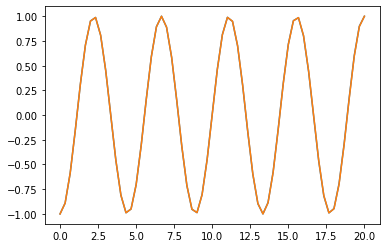

In [ ]:
from scipy.integrate import solve_ivp

def ydot(t,x):
  return np.array([x[2],x[3],k_truth*(x[1]-x[0]),k_truth*(x[0]-x[1])])

sol = solve_ivp(ydot, [0,20], np.array([-1,1,0,0]), t_eval=t)

plt.plot(t, sol.y[0,:])
plt.plot(t, x1[0,:])

In [ ]:
def check_gradient(model, t):

    eps = 1e-4
    dfdx_fd = (f(model, t + eps) - f(model, t - eps)) / (2 * eps)
    dfdx_sample = model.jacobian(t)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)

